<a href="https://colab.research.google.com/github/vienskaz/ECG-CNN/blob/main/FINALTUNEREKG_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras.utils import to_categorical
from scipy.signal import butter,filtfilt
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import classification_report
import keras_tuner as kt

In [4]:
synthetic_twos = np.loadtxt('/content/drive/MyDrive/ecg/twosleakyrelu.csv', delimiter=',')
synthetic_fours = np.loadtxt('/content/drive/MyDrive/ecg/foursleakyrelu.csv', delimiter=',')

In [5]:
mit_test_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [ ]:
print(len(Y_train)+len(Y_test))

109446


In [6]:
one = np.array([])
one_label = np.array([])
three = np.array([])
three_label = np.array([])
five = np.array([])
five_label = np.array([])


while one.shape[0] < 5000 or three.shape[0] < 5000 or five.shape[0] < 5000:
    for i in range(len(Y_train)):
        if np.array_equal(Y_train[i], [1.0, 0.0, 0.0, 0.0, 0.0]):
            if one.shape[0] < 5000:
                one = np.concatenate([one, [X_train[i]]]) if one.shape[0] > 0 else np.array([X_train[i]])
                one_label = np.concatenate([one_label, [[1.0, 0.0, 0.0, 0.0, 0.0]]]) if one_label.shape[0] > 0 else np.array([[1.0, 0.0, 0.0, 0.0, 0.0]])

        elif np.array_equal(Y_train[i], [0.0, 0.0, 1.0, 0.0, 0.0]):
            if three.shape[0] < 5000:
                three = np.concatenate([three, [X_train[i]]]) if three.shape[0] > 0 else np.array([X_train[i]])
                three_label = np.concatenate([three_label, [[0.0, 0.0, 1.0, 0.0, 0.0]]]) if three_label.shape[0] > 0 else np.array([[0.0, 0.0, 1.0, 0.0, 0.0]])

        elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 0.0, 1.0]):
            if five.shape[0] < 5000:
                five = np.concatenate([five, [X_train[i]]]) if five.shape[0] > 0 else np.array([X_train[i]])
                five_label = np.concatenate([five_label, [[0.0, 0.0, 0.0, 0.0, 1.0]]]) if five_label.shape[0] > 0 else np.array([[0.0, 0.0, 0.0, 0.0, 1.0]])




In [7]:
print("train", X_train.shape)
print("train", Y_train.shape)
print("one: ", one_label.shape)
print("one: ", one.shape)
print("three: ", three_label.shape)
print("three: ", three.shape)
print("five: ", five_label.shape)
print("five: ", five.shape)

train (87554, 187, 1)
train (87554, 5)
one:  (5000, 5)
one:  (5000, 187, 1)
three:  (5000, 5)
three:  (5000, 187, 1)
five:  (5000, 5)
five:  (5000, 187, 1)


In [7]:
two = np.array([])
four = np.array([])




for i in range(len(Y_train)):
    if np.array_equal(Y_train[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
          two = np.concatenate([two, [X_train[i]]]) if two.shape[0] > 0 else np.array([X_train[i]])


    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 1.0, 0.0]):
        four = np.concatenate([four, [X_train[i]]]) if four.shape[0] > 0 else np.array([X_train[i]])


In [ ]:
print("two: ", two.shape)
print("four: ", four.shape)

two:  (2223, 187, 1)
four:  (641, 187, 1)


In [8]:
def moving_average_filter(signal, window_size=5):
    filtered=[]
    for data in signal:
      filtered_ecg = np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')
      filtered.append(filtered_ecg)
    return np.array(filtered)


In [9]:
one = np.squeeze(one, axis=-1)
two = np.squeeze(two, axis=-1)
three=np.squeeze(three, axis=-1)
four = np.squeeze(four, axis=-1)
five = np.squeeze(five, axis=-1)


one= moving_average_filter(one)
two= moving_average_filter(two)
three= moving_average_filter(three)
four= moving_average_filter(four)
five= moving_average_filter(five)

merged_two = np.concatenate((two, synthetic_twos), axis=0)
merged_four = np.concatenate((four, synthetic_fours), axis=0)


In [10]:
X_train_f = np.concatenate((one, merged_two, three, merged_four, five))

In [11]:
two_label = np.array([0.0, 1.0, 0.0, 0.0, 0.0])

repetitions=5000

result_two_label = np.tile(two_label, (repetitions, 1))

four_label = np.array([0.0, 0.0, 0.0, 1.0, 0.0])


result_four_label = np.tile(four_label, (repetitions, 1))

print(result_four_label.shape)
print(result_two_label.shape)

(5000, 5)
(5000, 5)


In [12]:
Y_train = np.concatenate((one_label, result_two_label, three_label, result_four_label, five_label))

In [13]:
X_test_f=moving_average_filter(X_test)

In [14]:
from sklearn.model_selection import train_test_split


X_train, X_val, Y_train, Y_val = train_test_split(X_train_f, Y_train, test_size=0.2, random_state=42)



In [15]:
print(X_test_f.shape)
print(X_train_f.shape)
print(Y_test.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(21892, 187)
(25000, 187)
(21892, 5)
(20000, 5)
(5000, 187)
(5000, 5)


In [20]:
def build_model(hp):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(hp.Int('filter_1', min_value=16, max_value=128, step=16),
                            kernel_size=hp.Int('kernelsize_1', min_value=3, max_value=10, step=1),
                            activation='relu', input_shape=(187, 1)))

    for i in range(hp.Int('n_conv_layers', 1, 3)):
        units = hp.Int(f"conv_{i}_units", min_value=16, max_value=512, step=32)
        kernel_size = hp.Int(f"conv_{i}_kernelsize", min_value=3, max_value=5, step=1)
        model.add(layers.Conv1D(units, kernel_size=kernel_size, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Flatten())

    # Dense layers
    for i in range(hp.Int('n_dense_layers', 1, 3)):
        units = hp.Int(f"dense_{i}_units", min_value=16, max_value=1024, step=64)
        model.add(layers.Dense(units, activation='relu'))

    model.add(layers.Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

In [22]:
tuner=kt.Hyperband(build_model,
                   objective='val_accuracy',
                   max_epochs=30,
                   factor=3,
                   directory='ecg_modelv1',
                   project_name='x')



In [23]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)


In [24]:
tuner.search(X_train, Y_train, epochs=30, validation_data=(X_val,Y_val), callbacks=[stop_early])


Trial 90 Complete [00h 01m 55s]
val_accuracy: 0.9616000056266785

Best val_accuracy So Far: 0.968999981880188
Total elapsed time: 00h 47m 35s


In [29]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [30]:
model=tuner.hypermodel.build(best_hps)
history=model.fit(X_train,Y_train,epochs=20,callbacks=[stop_early])

Epoch 1/20
623/625 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8649

625/625 [==============================] - 15s 14ms/step - loss: 0.3858 - accuracy: 0.8650
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9353

625/625 [==============================] - 5s 8ms/step - loss: 0.1981 - accuracy: 0.9353
Epoch 3/20
621/625 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9503

625/625 [==============================] - 6s 9ms/step - loss: 0.1460 - accuracy: 0.9505
Epoch 4/20
622/625 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9583

625/625 [==============================] - 5s 8ms/step - loss: 0.1187 - accuracy: 0.9583
Epoch 5/20
620/625 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9663

625/625 [==============================] - 5s 8ms/step - loss: 0.1001 - accuracy: 0.9663
Epoch 6/20
623/625 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9704

625/625 [==============================] - 5s 9ms/step - loss: 0.0853 - accuracy: 0.9704
Epoch 7/20
621/625 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9730

625/625 [==============================] - 5s 8ms/step - loss: 0.0760 - accuracy: 0.9731
Epoch 8/20
623/625 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9773

625/625 [==============================] - 5s 8ms/step - loss: 0.0653 - accuracy: 0.9773
Epoch 9/20
625/625 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9828

625/625 [==============================] - 5s 9ms/step - loss: 0.0474 - accuracy: 0.9828
Epoch 10/20
619/625 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9799

625/625 [==============================] - 5s 8ms/step - loss: 0.0559 - accuracy: 0.9799
Epoch 11/20
624/625 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9861

625/625 [==============================] - 5s 8ms/step - loss: 0.0414 - accuracy: 0.9861
Epoch 12/20
621/625 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9852

625/625 [==============================] - 5s 9ms/step - loss: 0.0422 - accuracy: 0.9851
Epoch 13/20
622/625 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9858

625/625 [==============================] - 5s 8ms/step - loss: 0.0420 - accuracy: 0.9857
Epoch 14/20
625/625 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9877

625/625 [==============================] - 5s 8ms/step - loss: 0.0370 - accuracy: 0.9877
Epoch 15/20
620/625 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9883

625/625 [==============================] - 6s 9ms/step - loss: 0.0323 - accuracy: 0.9883
Epoch 16/20
625/625 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9896

625/625 [==============================] - 5s 8ms/step - loss: 0.0292 - accuracy: 0.9896
Epoch 17/20
621/625 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9905

625/625 [==============================] - 5s 8ms/step - loss: 0.0281 - accuracy: 0.9905
Epoch 18/20
621/625 [============================>.] - ETA: 0s - loss: 0.0305 - accuracy: 0.9897

625/625 [==============================] - 5s 8ms/step - loss: 0.0304 - accuracy: 0.9898
Epoch 19/20
625/625 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9916

625/625 [==============================] - 5s 8ms/step - loss: 0.0260 - accuracy: 0.9916
Epoch 20/20
621/625 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9919

625/625 [==============================] - 5s 8ms/step - loss: 0.0210 - accuracy: 0.9919


In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 180, 80)           720       
                                                                 
 conv1d_9 (Conv1D)           (None, 177, 304)          97584     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 88, 304)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 85, 240)           292080    
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 42, 240)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 40, 176)          

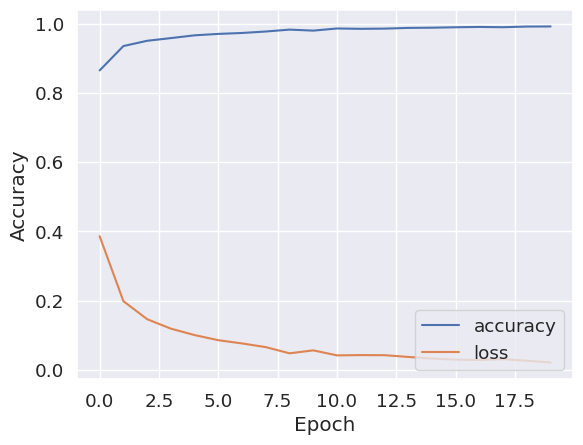

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

In [39]:
loss, accuracy=model.evaluate(X_test_f,Y_test)
print(f'Loss={loss}')
print(f'{accuracy * 100:.2f}%')

685/685 [==============================] - 4s 6ms/step - loss: 0.1933 - accuracy: 0.9582
Loss=0.19325754046440125
95.82%


In [35]:
model.save('/content/drive/MyDrive/ecg/finalymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
model=tf.keras.models.load_model('/content/drive/MyDrive/ecg/finalymodel.h5')

In [44]:
!zip -r /content/ecg_modelv1.zip /content/ecg_modelv1

  adding: content/ecg_modelv1/ (stored 0%)
  adding: content/ecg_modelv1/x/ (stored 0%)
  adding: content/ecg_modelv1/x/trial_0079/ (stored 0%)
  adding: content/ecg_modelv1/x/trial_0079/checkpoint.index (deflated 59%)
  adding: content/ecg_modelv1/x/trial_0079/checkpoint.data-00000-of-00001 (deflated 25%)
  adding: content/ecg_modelv1/x/trial_0079/trial.json (deflated 81%)
  adding: content/ecg_modelv1/x/trial_0079/checkpoint (deflated 48%)
  adding: content/ecg_modelv1/x/trial_0089/ (stored 0%)
  adding: content/ecg_modelv1/x/trial_0089/checkpoint.index (deflated 63%)
  adding: content/ecg_modelv1/x/trial_0089/checkpoint.data-00000-of-00001 (deflated 22%)
  adding: content/ecg_modelv1/x/trial_0089/trial.json (deflated 81%)
  adding: content/ecg_modelv1/x/trial_0089/checkpoint (deflated 48%)
  adding: content/ecg_modelv1/x/trial_0007/ (stored 0%)
  adding: content/ecg_modelv1/x/trial_0007/checkpoint.index (deflated 63%)
  adding: content/ecg_modelv1/x/trial_0007/checkpoint.data-00000-

685/685 [==============================] - 2s 3ms/step
Confusion Matrix:
tf.Tensor(
[[17430   325   205   104    54]
 [   70   471    14     1     0]
 [   31    16  1354    38     9]
 [   11     2     7   142     0]
 [   18     4     6     1  1579]], shape=(5, 5), dtype=int32)


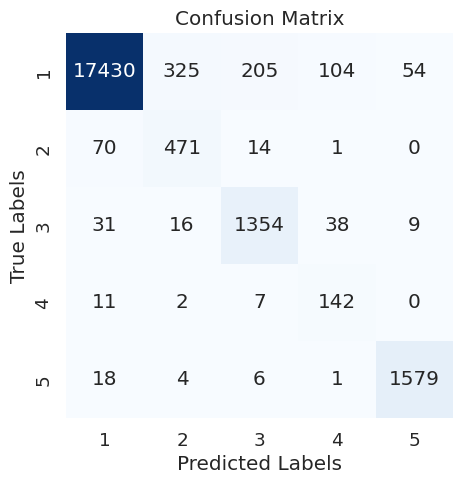

In [37]:
y_pred = model.predict(X_test_f)
y_pred_classes = tf.argmax(y_pred, axis=1)


y_test = y_test.astype(int)


confusion_matrix = tf.math.confusion_matrix(y_test, y_pred_classes, num_classes=5)
print("Confusion Matrix:")
print(confusion_matrix)


plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [38]:
classification_rep = classification_report( y_test , y_pred_classes)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.58      0.85      0.69       556
           2       0.85      0.94      0.89      1448
           3       0.50      0.88      0.63       162
           4       0.96      0.98      0.97      1608

    accuracy                           0.96     21892
   macro avg       0.78      0.92      0.83     21892
weighted avg       0.97      0.96      0.96     21892

